In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from pathlib import Path
import time
import numpy as np
import matplotlib.pyplot as plt

# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

MAX_LEN = 128

/Users/purusoni/miniconda3/envs/youtube_classifier_extention/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
labeled_mapped_csv_path = Path.cwd() / "labeled_mapped.csv"

labels_to_ids = {
    "Educational": 0,
    "Entertainment": 1,
}

num_labels = len(labels_to_ids)

In [3]:
# Load data from CSV file
df = pd.read_csv(labeled_mapped_csv_path)

# Read header for column names
column_names = df.columns.tolist()
print("Column names:", column_names)
print("Dataframe shape:", df.shape)

# Print number of elements for each label
print()
print("Elements per label before making them equal:")
print(df['label'].value_counts())

# Only retain equal number of elements for each label
least_number_of_elements = df['label'].value_counts().min()
df = df.groupby('label').head(least_number_of_elements).reset_index(drop=True)

# Print number of elements for each label
print()
print("Elements per label after making them equal:")
print(df['label'].value_counts())

print()
print("Dataframe shape:", df.shape)
print("Dataframe head:")
print(df.head())


Column names: ['label', 'title', 'path']
Dataframe shape: (2736, 3)

Elements per label before making them equal:
label
Entertainment    1825
Educational       911
Name: count, dtype: int64

Elements per label after making them equal:
label
Entertainment    911
Educational      911
Name: count, dtype: int64

Dataframe shape: (1822, 3)
Dataframe head:
           label                                              title   path
0  Entertainment  SIDEMEN GUESS THE LINK OFFENSIVE EDITION by Mo...  1.jpg
1  Entertainment  Our Most Demonic Experience  Zak Bagans Haunte...  2.jpg
2  Entertainment  How SpaceX and Boeing will get Astronauts to t...  3.jpg
3  Entertainment  'TIRED OF IT' Voters sound off after latest at...  4.jpg
4    Educational  Can We Predict An Outbreak's Future - Modeling...  5.jpg


In [4]:
print("Max length of a title in the Dataframe:", df['title'].map(len).max())

Max length of a title in the Dataframe: 135


In [5]:
# Split data into labels and titles
all_labels = df["label"].tolist()
all_titles = df["title"].tolist()

# Print first 5 all_labels and all_titles
print(all_labels[:5])

# Convert all_labels to integers
all_labels = np.vectorize(labels_to_ids.get)(all_labels)
print(all_labels[:5])

# all_labels = to_categorical(all_labels)
# print(all_labels[:10])

print(all_titles[:5])
print("Lenght of dataset: ", len(all_labels))

['Entertainment', 'Entertainment', 'Entertainment', 'Entertainment', 'Educational']
[1 1 1 1 0]
['SIDEMEN GUESS THE LINK OFFENSIVE EDITION by MoreSidemen', 'Our Most Demonic Experience  Zak Bagans Haunted Museum by Sam and Colby', 'How SpaceX and Boeing will get Astronauts to the ISS by EverydayAstronaut', "'TIRED OF IT' Voters sound off after latest attacks on Trump by FoxNews", "Can We Predict An Outbreak's Future - Modeling Crash Course Outbreak Science #9 by crashcourse"]
Lenght of dataset:  1822


In [6]:
tokenizer = BertTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
tiny_bert_model = TFBertForSequenceClassification.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', from_pt = True, num_labels=num_labels)
tiny_bert_model.summary()

2023-08-16 18:07:50.125162: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-08-16 18:07:50.125205: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-08-16 18:07:50.125211: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-08-16 18:07:50.125255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-16 18:07:50.125277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['fit_denses.0.bias', 'fit_denses.2.bias', 'fit_denses.1.weight',

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  14350248  
                                                                 
 dropout_13 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  626       
                                                                 
Total params: 14350874 (54.74 MB)
Trainable params: 14350874 (54.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
sentences_train_val, sentences_test, labels_train_val, labels_test = train_test_split(all_titles, all_labels, test_size=0.2, random_state=42)

In [8]:
train_val_encodings = tokenizer(sentences_train_val, truncation=True, padding=True, max_length=MAX_LEN)
test_encodings = tokenizer(sentences_test, truncation=True, padding=True, max_length=MAX_LEN)

print(train_val_encodings.keys())
print(train_val_encodings['input_ids'][0])
print(train_val_encodings['attention_mask'][0])

train_val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_val_encodings),
    labels_train_val
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    labels_test
))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
[101, 4748, 14945, 4335, 2189, 5702, 2189, 2005, 2488, 6693, 1998, 3579, 1010, 2817, 2189, 2011, 2665, 5596, 5453, 1011, 19613, 2189, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
valid_size = int(0.25 * len(train_val_dataset)) 

val_dataset = train_val_dataset.take(valid_size) 
train_dataset = train_val_dataset.skip(valid_size) 

print("Train dataset length: ", len(list(train_dataset)))
print("Validation dataset length: ", len(list(val_dataset)))
print("Test dataset length: ", len(list(test_dataset)))

Train dataset length:  1093
Validation dataset length:  364
Test dataset length:  365


In [10]:
model = TFBertForSequenceClassification.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', from_pt = True, num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4,
    verbose=1,
    mode='min',
    restore_best_weights=True,
)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(
    train_dataset.batch(4), 
    epochs=200, 
    batch_size=4, 
    validation_data=val_dataset.batch(4), 
    callbacks=[early_stopping]
)

model.save_pretrained('tinybert_fine_tuned')
tokenizer.save_pretrained('tinybert_fine_tuned')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['fit_denses.0.bias', 'fit_denses.2.bias', 'fit_denses.1.weight', 'fit_denses.4.weight', 'fit_denses.1.bias', 'fit_denses.3.bias', 'fit_denses.2.weight', 'fit_denses.4.bias', 'fit_denses.3.weight', 'fit_denses.0.weight']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classif

Epoch 1/200


2023-08-16 18:07:54.685121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


274/274 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.6615

2023-08-16 18:08:21.456498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


274/274 [==============================] - 34s 105ms/step - loss: 0.6640 - accuracy: 0.6615 - val_loss: 0.5693 - val_accuracy: 0.8022
Epoch 2/200
274/274 [==============================] - 25s 90ms/step - loss: 0.4966 - accuracy: 0.8124 - val_loss: 0.4107 - val_accuracy: 0.8626
Epoch 3/200
274/274 [==============================] - 25s 90ms/step - loss: 0.3588 - accuracy: 0.8783 - val_loss: 0.3658 - val_accuracy: 0.8599
Epoch 4/200
274/274 [==============================] - 25s 89ms/step - loss: 0.2802 - accuracy: 0.9122 - val_loss: 0.3546 - val_accuracy: 0.8681
Epoch 5/200
274/274 [==============================] - 25s 90ms/step - loss: 0.2264 - accuracy: 0.9323 - val_loss: 0.3676 - val_accuracy: 0.8791
Epoch 6/200
274/274 [==============================] - 25s 90ms/step - loss: 0.1915 - accuracy: 0.9478 - val_loss: 0.3887 - val_accuracy: 0.8599
Epoch 7/200
274/274 [==============================] - 25s 89ms/step - loss: 0.1528 - accuracy: 0.9625 - val_loss: 0.3916 - val_accuracy: 0.8

('tinybert_fine_tuned/tokenizer_config.json',
 'tinybert_fine_tuned/special_tokens_map.json',
 'tinybert_fine_tuned/vocab.txt',
 'tinybert_fine_tuned/added_tokens.json')

In [16]:
model.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  14350248  
                                                                 
 dropout_55 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  626       
                                                                 
Total params: 14350874 (54.74 MB)
Trainable params: 14350874 (54.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


KeyError: 'loss'

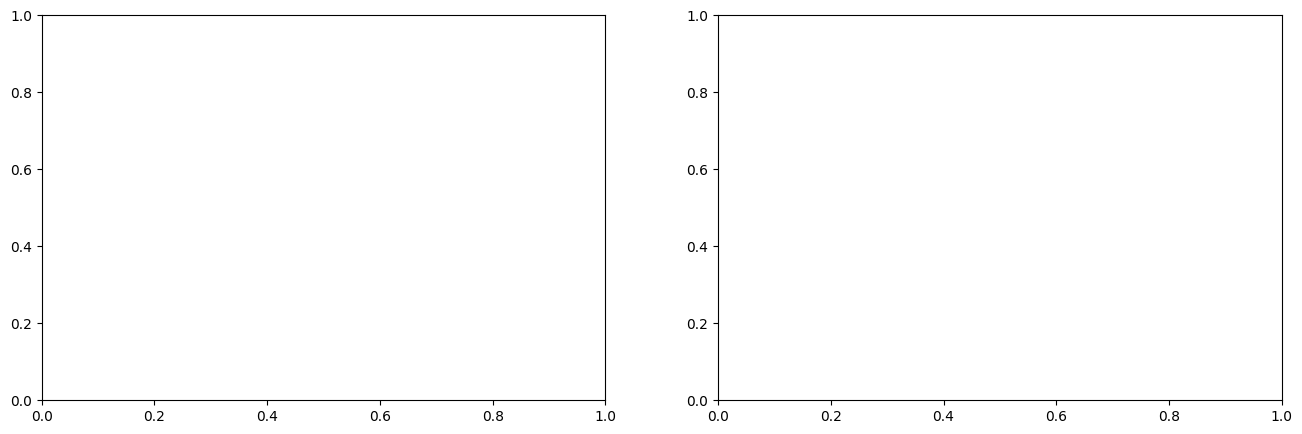

In [17]:
# Visualize the training process
history = model.history

figure, axis = plt.subplots(1, 2, figsize=(16, 5))
axis[0].plot(history.history['loss'], label='Training Loss')
axis[0].plot(history.history['val_loss'], label='Validation Loss')
axis[0].set_title('Training and Validation Loss')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].legend()

axis[1].plot(history.history['accuracy'], label='Training Accuracy')
axis[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axis[1].set_title('Training and Validation Accuracy')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
axis[1].legend()

plt.show()

In [18]:
# Test the model
model = TFBertForSequenceClassification.from_pretrained('tinybert_fine_tuned')
tokenizer = BertTokenizer.from_pretrained('tinybert_fine_tuned')
model.compile(metrics=['accuracy'])

print('Evaluate on test data')
results = model.evaluate(test_dataset.batch(2), batch_size=2)

Some layers from the model checkpoint at tinybert_fine_tuned were not used when initializing TFBertForSequenceClassification: ['dropout_27']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at tinybert_fine_tuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Evaluate on test data


2023-08-16 18:11:31.415484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


183/183 [==============================] - 10s 43ms/step - loss: 0.4013 - accuracy: 0.8356


In [54]:
# Calculate time taken to process one title
# 1. Load model
# 2. Load tokenizer
# 3. Load title
# 4. Tokenize title
# 5. Predict
# 6. Calculate time taken

model = TFBertForSequenceClassification.from_pretrained('tinybert_fine_tuned')
tokenizer = BertTokenizer.from_pretrained('tinybert_fine_tuned')
model.compile(metrics=['accuracy'])


Some layers from the model checkpoint at tinybert_fine_tuned were not used when initializing TFBertForSequenceClassification: ['dropout_27']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at tinybert_fine_tuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [95]:
title = "How to bake a simple homemade minecraft server"

start_time = time.time()
title_encoding = tokenizer(title, truncation=True, padding=True, max_length=MAX_LEN)
prediction = model.predict([title_encoding['input_ids'], title_encoding['attention_mask']])
prediction = np.argmax(prediction[0], axis=1)[0]
print("Time taken to predict:", time.time() - start_time)
print("Title: ", title)
print("Prediction: ", ["Education", "Entertainment"][prediction])

1/1 [==============================] - 0s 169ms/step
Time taken to predict: 0.19353485107421875
Title:  How to bake a simple homemade minecraft server
Prediction:  Entertainment
